In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import cv2
import matplotlib.pyplot as plt

In [2]:
class VisualBagOfWords:
    def __init__(self):
        # tf-idf scores of images
        self.tf_idf = []
        # Inverse document frequency of images
        self.inv_doc_freq = []
        # K means estimator
        self.estimator = None
        # Cluster size
        self.k = 0
    
    
    def divideImageToCells(self,image):
        M = image.shape[0]
        N = image.shape[1]
        # Dividing the image into 16*16 gird of cells
        m = M//16
        n = N//16

        M = m*16   # To make sure that m is multiple of M, so that we do not get smaller strip at the end of images
        N = n*16
        cells = []
        for i in range(0,M,m):
            for j in range(0,N,n):
                cells.append(image[i:i+m, j:j+n, :]) 
        return cells
    
    def calculateMSTDofCells(self,cells):
        # According to the given paper, each cell converted into a 6 dimensional vector
        # mean and standard deviation of R/R+B+G, G/R+B+G and R+B+G/3*255
        # Channel 0, 1 and 2 correspond to the color Red, Green and Blue.
        no_of_cells = len(cells)
        MSTD = []

        for i in range(no_of_cells):
            _6_d_vector = np.zeros(6)

            # We add div_array to the denominator so that we avoid RTE division by 0, when all channels are 0 (black pixel)
            div_array = np.ones((cells[0].shape[0], cells[0].shape[1]))*1e-7

            data = [None, None, None]
            data[0] = np.divide(cells[i][:,:,0], cells[i][:,:,0]+cells[i][:,:,1]+cells[i][:,:,2]+div_array)
            data[1] = np.divide(cells[i][:,:,1], cells[i][:,:,0]+cells[i][:,:,1]+cells[i][:,:,2]+div_array)
            data[2] = (cells[i][:,:,0]+cells[i][:,:,1]+cells[i][:,:,2])/(3*255)

            for i in range(3):
                _6_d_vector[2*i] = np.mean(data[i])         # Mean
                _6_d_vector[2*i + 1] = np.std(data[i])      # Standard deviation

            MSTD.append(_6_d_vector)

        return MSTD
    def performKMeans(self, all_cell_statistics, cluster_size):
        self.k = cluster_size
        self.estimator = KMeans(n_clusters=self.k, random_state=42).fit(all_cell_statistics)

    def getVisualTermsOfImage(self,new_image):
        cells = self.divideImageToCells(new_image)           # Divide the image into cells
        statistics = self.calculateMSTDofCells(cells)         # Calculate the statistics for all the cells
        visual_terms = self.estimator.predict(statistics)
        return visual_terms


    def computeTfIdfScoredMSTD(self, images):
        # contains the term frequency of each image
        document_frequency = np.zeros(self.k)

        tf_idf = []
        print("Calculating tf-idf scores ...")
        
        for i in tqdm(range(len(images))):
            
            term_frequency = np.zeros(self.k)
            # Return labels of 256 cells of the images
            visual_terms = self.getVisualTermsOfImage(images[i])
            
            # Calculate the histogram
            for i in range(self.k):
                term_frequency[visual_terms[i]]+=1 
            # Add the elements that appear in this document
            document_frequency += (term_frequency>0)*1
            
            # K is 1.2 in Okapi formula. b is not necessary as the average size of documents is same as document size for all images
            term_frequency = (term_frequency*(1.2+1))/(term_frequency+1.2)
            tf_idf.append(term_frequency)
        
        inverse_document_frequency = np.log2((len(images)-document_frequency + 0.5)/(document_frequency+0.5))
        for i in range(len(images)):
            tf_idf[i] *= inverse_document_frequency
            
        self.tf_idf = tf_idf
        self.inv_doc_freq = inverse_document_frequency
        

    def calculateVisualScore(self,query_image):
        visual_terms_query = self.getVisualTermsOfImage(query_image)
        # The below is calculated according to the okapi method. Here term_frequency_query is same as qtw in paper
        term_frequency_query = np.zeros(self.k)
        for i in range(self.k):
                term_frequency_query[visual_terms_query[i]]+=1 
        
        # Here k_3 is 7, defined in okapi formula
        term_frequency_query = (term_frequency_query*(7+1))/(term_frequency_query+7)

        scores = np.zeros(len(self.tf_idf))
        print("Calculating scores ...")
        
        for i in tqdm(range(len(self.tf_idf))):
            score = np.sum(term_frequency_query*self.tf_idf[i])
            scores[i] = score
        
        matching_image_indices = scores.argsort()[::-1][:10]
        scores.sort()
        matching_image_scores = scores[::-1][:10]

        return matching_image_indices, matching_image_scores
    
    
    def prepareVisualBagOfWords(self, DATASET, cluster_size):
        all_cells_MSTD = []
        cells = MSTD = None 
        
        print('Dividing the images into cells, and calculating the statistics of each cell')
        
        for i in tqdm(range(len(DATASET))):
            cells = self.divideImageToCells(DATASET[i])
            MSTD = self.calculateMSTDofCells(cells)
            all_cells_MSTD += MSTD 
        
        print('Performing K-means on MSTD of images')
        self.performKMeans(all_cells_MSTD, cluster_size)  

In [3]:
tf_idf_visual = None
image_bow = None

# Reading the Visual bag of words object, to get tf_idf scores
with open('visualbagofwords.pkl', 'rb') as obj:
    image_bow =  pickle.load(obj)
    
tf_idf_visual = image_bow.tf_idf

E:\Anaconda3\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator KMeans from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
print(len(tf_idf_visual))

10000


In [5]:
# Reading all the descriptions to calculate the tf_idf scores.
DATADIR = "D:/ImageCLEFphoto2008/annotations_complete_eng"
subfolders = os.listdir(DATADIR)
texts_path = []
texts = []
path = ''
for subfolder in subfolders:

    path = DATADIR+'/'+subfolder+'/'
    texts = os.listdir(path)

    for textpath in texts:
        texts_path.append(path+textpath)
print(len(texts_path))    

# GETTING THE PATHS FOR DESCRIPTIONS
np.random.seed(42)
np.random.shuffle(texts_path)  # Randomly shuffling the image names 
random_selection_text = np.random.choice(texts_path, 10000,replace=False)

# READING THE DESCRIPTIONS
DATASET_descriptions = []

annotation = None
desc = None

for i in tqdm(range(len(random_selection_text))):
    with open(random_selection_text[i], 'r', encoding='latin-1') as file:
        annotation = file.read()
        desc = [string.strip() for string in re.findall(r'<DESCRIPTION>(.*?)</DESCRIPTION>', annotation, re.DOTALL)]
        DATASET_descriptions.append(desc[0].replace(';',''))

20000


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
vectorizer =  TfidfVectorizer()
tf_idf_textual = vectorizer.fit_transform(DATASET_descriptions)
print(tf_idf_textual.shape)

(10000, 3579)


In [7]:
tf_idf_textual[0]

<1x3579 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [8]:
def evaluateQuery(description, image, tf_idf_textual, tf_idf_visual, image_bow, vectorizer):
    tf_idf_query = vectorizer.transform([description])
    scores_T = []
    scores_V = []
    for tf_idf in tf_idf_textual:
        scores_T.append(tf_idf.multiply(tf_idf_query).sum())
    
    visual_terms_query = image_bow.getVisualTermsOfImage(image)
    # The below is calculated according to the okapi method. Here term_frequency_query is same as qtw in paper
    term_frequency_query = np.zeros(image_bow.k)
    for i in range(image_bow.k):
            term_frequency_query[visual_terms_query[i]]+=1 

    # Here k_3 is 7, defined in okapi formula
    term_frequency_query = (term_frequency_query*(7+1))/(term_frequency_query+7)

    for i in range(len(tf_idf_visual)):
        score = np.sum(term_frequency_query*tf_idf_visual[i])
        scores_V.append(score)
    
    return (scores_T, scores_V)

In [9]:
test_image = cv2.imread("D:/ImageCLEFphoto2008/images/08/8018.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

In [10]:
s_T, s_V = evaluateQuery("a man sitting on a bike", test_image, tf_idf_textual, tf_idf_visual, image_bow, vectorizer)

In [11]:
X = []
for i in range(len(s_T)):
    X.append([s_T[i], s_V[i]])

In [12]:
def learn_parameter(X, Xr, Xr_):
    
    # mean vector of whole doc 
    mean_vectors = [] 
    for i in range(X.shape[1]):
        mean_vectors.append(np.mean(X[i]))
    
    # mean of the relevant docs
    relevant_mean_vectors = []
    for j in range(len(Xr)):
        relevant_mean_vectors.append(np.mean(Xr[j]))
    
    # mean of the non-relevant docs
    nonrelevant_mean_vectors = []
    for k in range(len(Xr_)):
        nonrelevant_mean_vectors.append(np.mean(Xr_[k]))
    
    # between class scatter matrix
    rel_mean_diff = (relevant_mean_vectors - mean_vectors)
    rel = len(Xr)*np.dot(rel_mean_diff.T, rel_mean_diff)
    
    nonrel_mean_diff = (nonrelevant_mean_vectors - mean_vectors)
    nonrel = len(Xr_)*np.dot(nonrel_mean_diff.T, nonrel_mean_diff)
    
    B = (rel + nonrel)/len(X)
    print(B)
    print(rel)
    print(nonrel)
    
    # calculating the covariance matrix
    T = np.zeros((len(X), len(X)))
    for i, vec in tqdm(enumerate(X)):
        #vec = vec.reshape(len(X))
        Ti = vec - X[i]
        
        T += (np.dot(Ti.T, Ti))/len(X) # covariance matrix
        
    T_inv = np.linalg.pinv(T)
    T_inv_B = np.dot(T_inv, B)
    
    eigen_values, eigen_vectors = np.linalg.eig(T_inv_B)
    
    # the solution to learn the parameter is the first eigen vector from the fisher criterion
    return eigen_vectors[0]

In [13]:
def learn_parameters_vect(X, Xr, Xr_):   # X = 10000X2
    
    mean_X = np.mean(X, axis=0)
    
    # Mean subtraction from X
    for i in range(X.shape[0]):
        X[i]-=mean_X
    
    mean_Xr = np.mean(Xr, axis=0)
    mean_Xr_ = np.mean(Xr_, axis=0)
    
    rel_mean_sub = np.reshape(mean_Xr - mean_X , (1,2))  # shape 1X2
    non_rel_mean_sub = np.reshape(mean_Xr_ - mean_X , (1,2))  # shape 1X2
    
    
    B = (1/X.shape[0])*(Xr.shape[0]*(np.matmul(rel_mean_sub.T, rel_mean_sub))  + Xr_.shape[0]*(np.matmul(non_rel_mean_sub.T, non_rel_mean_sub)) )
    T = 1/X.shape[0]*(np.matmul(X.T, X))
    
    T_inv = np.linalg.inv(T)
    solution = np.matmul(T_inv, B)
    eigen_values, eigen_vectors = np.linalg.eig(solution)
    
    return eigen_vectors[0]
    

In [14]:
X = sorted(X, key= lambda x:x[0], reverse=True)
Xr = X[:5000]
Xr_ = X[5000:]

X = np.array(X)
Xr = np.array(Xr)
Xr_ = np.array(Xr_)

In [15]:
alpha = learn_parameters_vect(X, Xr, Xr_)

In [16]:
alpha

array([0.99999999, 0.99921337])

In [17]:
def compute_final_scores(alpha, scoresT, scoresV):
    final_scores = alpha[0]*scoresT + alpha[1]*scoresV
    return final_scores

In [18]:
final_scores = compute_final_scores(alpha, np.array(s_T), np.array(s_V))

In [19]:
image_names = []
with open('validimagenames.pkl', 'rb') as file:
    image_names = pickle.load(file)
    
indices = final_scores.argsort()[::-1][:10]

matching_image_names = []
for i in indices:
    matching_image_names.append(image_names[i])

In [20]:
matching_image_names

['18/18459.jpg',
 '08/8945.jpg',
 '37/37705.jpg',
 '07/7516.jpg',
 '38/38729.jpg',
 '19/19233.jpg',
 '12/12490.jpg',
 '13/13911.jpg',
 '08/8018.jpg',
 '00/925.jpg']

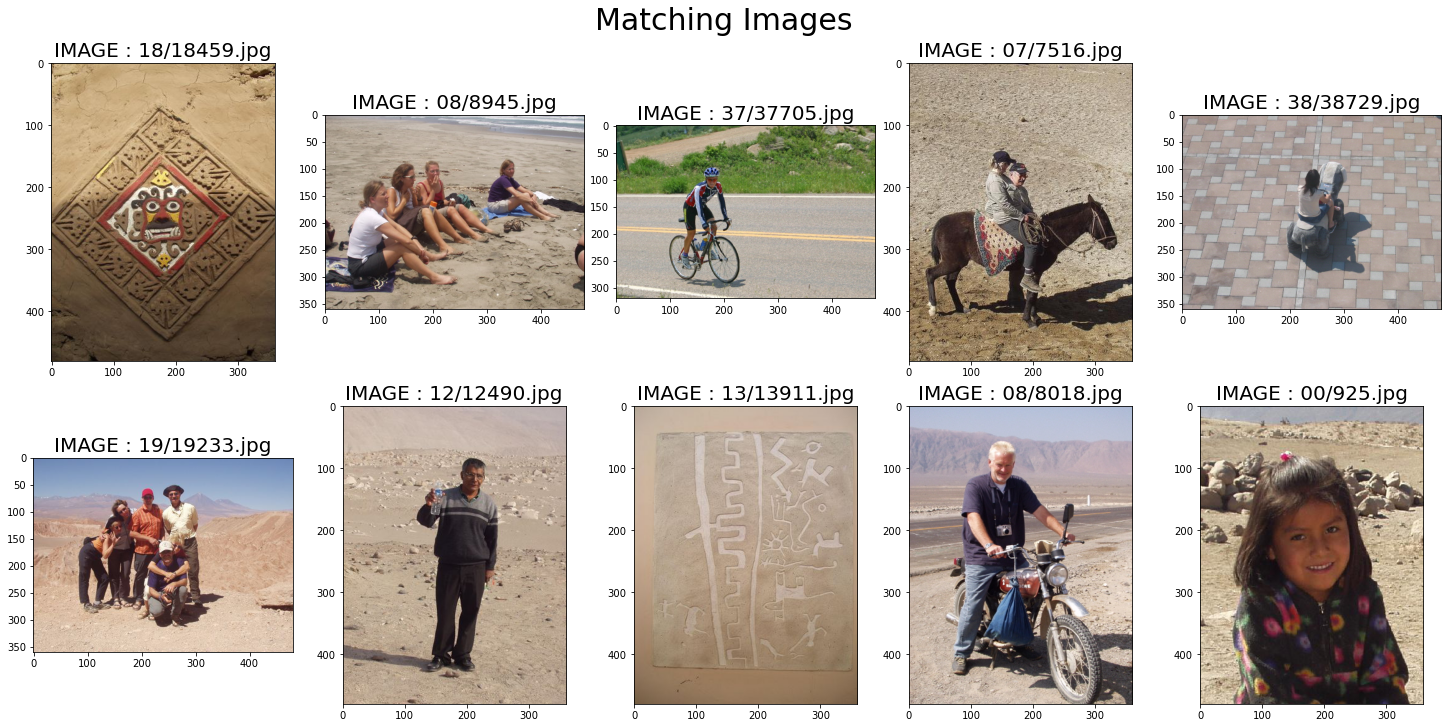

In [21]:
image_path = "D:/ImageCLEFphoto2008/images/"
output_images = []
for i in range(10):
    output_images.append( cv2.cvtColor(cv2.imread(image_path+matching_image_names[i]), cv2.COLOR_BGR2RGB))
    

fig, ax = plt.subplots(2,5,figsize=(20,10),constrained_layout=True)

fig.suptitle('Matching Images',size =30)
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(output_images[5*i+j])
        ax[i,j].set_title("IMAGE : "+matching_image_names[5*i+j], size = 20)

# ________________________________________________________________________

# 